# WCAI Workshop
**Description**: Social media has transformed in the past decade to the benefit of market researchers. Where users who were once interested in connecting with friends & family through Facebook are now choosing to connect with interests and products as anonymized users through platforms like Reddit, Twitter, and Tumblr. We will leverage publicly available Reddit data to understand the playerbase of The Sims, a life simulation game, by drawing out insights of who they are and what EA should develop next for the game. I will walk through the data utilizing social network analysis to perform community detection as well as inferring engagement and drawing out competitors.

## The Sims
Electronic Arts publishes a life simulation game developed by Maxis called **The Sims**. What makes The Sims interesting is that it emulates life and gives the player power to make their own life. So it becomes natural to discover what interests the players have so that we can make a better sandbox with assets they would want to play with. This is why we look to social media of our players to get a sense of what we should do next.
![The Sims 4](https://www.ea.com/bundles/eathesims/dist/images/share/share_default.jpg)

## Why Reddit
Perhaps more than almost any product consumed, games define Gamers and these players are happy to declare their love for their preferred product. Gamers want to talk about the games they're currently playing with other people.
![Reddit](http://www.vectorico.com/download/social_media/Reddit-logo.jpg)

Furthermore, rather than families, coworkers, and acquaintences, gamers are caring more about content than they do about contacts. The young adults and even younger audience who play games are going to places like Reddit and instantly getting a community of players and news without any commitment like having to keep up with contacts or friends - they'd rather just play with them and interact in-game.

Another reason is that Reddit has discrete communities of interest called *Subreddits*. This makes it easy for users to find a topic or interest that they like, and likewise, easier for us to identify what content the users are engaging in. We don't have to make entity recognition for every edge case for say topics like *The Sims*, *Game of Thrones*, or *NFL* - the subreddit itself is the identifier.

## Who Plays The Sims?
As the creators, we can look at in-game telemetry and insight to how the game is being played with the existing content. Since the Sims is a life simulator we might want to understand the interests the players have in their own lives that we may want to create content for. Additionally, we may want to understand what other games compete for our player's time.

### Import Packages

In [19]:
from os import path
import sys
import re
import pandas as pd
import numpy as np
# import community
# import networkx as nx
import matplotlib.pyplot as plt
# import matplotlib
from igraph import *
from random import sample, seed
from time import time
from pprint import pprint
from IPython.display import Image
from itertools import combinations

from IPython.display import HTML, display


# Double Check
print(sys.executable)
print(sys.exec_prefix)

# # Figure size
# matplotlib.rcParams['figure.figsize'] = (13.5, 5.0)

# Make igraphs verbose
igraph_config=Configuration()
igraph_config["general.verbose"] = True

data_path = '../data'

/anaconda3/envs/wcai_36/bin/python
/anaconda3/envs/wcai_36


### Load Data
We have provided data aggregated from Reddit's API as a CSV. Here we import as a Pandas dataframe.
The data set is a count of posts and comments on all subreddits for all users who have ever commented or posted in the [**r/thesims**](https://www.reddit.com/r/thesims/) subreddit from January to July 2018.

In [20]:
# Read in data
data = pd.read_csv(path.join(data_path, "thesims_activity_201801_201807.bz2"))
# data = pd.read_csv(path.join(data_path, "thesims_activity_201808_201810.csv"))

print("The data has n = {0} rows and m = {1} columns.".format(*data.shape))

# Remove [deleted] usernames and Bots
author_list = data.author.unique()
bot_list = [author for author in author_list if re.match('.*bot$', author, re.IGNORECASE)]
remove_list = ['[deleted]','apk-downloader','TotesMessenger','','Bot_Metric','B0tRank','HelperBot_']
print("Removing authors [{0}]".format(', '.join(bot_list + remove_list)))
data = data[~data.author.isin(remove_list + bot_list)]

print("The data has n = {0} rows and m = {1} columns after removing bots and other authors.".format(*data.shape))

# Fix some Advertiser Categories
game_subreddits = ['AnimalCrossing','StardewValley','NintendoSwitch']
data.loc[data.subreddit.isin(game_subreddits), 'advertiser_category'] = 'Games'

# Preview dataset
data.head()

The data has n = 5280426 rows and m = 6 columns.
Removing authors [ZoeIsARobot, captcha_bot, gyrobot, NateNMaxsRobot, MaxImageBot, bleep_the_robot, LimbRetrieval-Bot, PressFBot, anti-gif-bot, AlexaPlayBot, YTubeInfoBot, ClickableLinkBot, The_Plumbot, dadjokes_bot, table_it_bot, SmallSubBot, FatFingerHelperBot, aardBot, PORTMANTEAU-BOT, oofed-bot, TitleToImageBot, sneakpeekbot, phonebatterylevelbot, thank_mr_skeltal_bot, tweettranscriberbot, timestamp_bot, RemindMeBot, gifv-bot, timezone_bot, WikiTextBot, AnimalFactsBot, timee_bot, [deleted], apk-downloader, TotesMessenger, , Bot_Metric, B0tRank, HelperBot_]
The data has n = 1348094 rows and m = 6 columns after removing bots and other authors.


,author,created_dt,subreddit,advertiser_category,posts,comments
0,Janiciar94,2018-06-13,WEPES,NaN,1.0,NaN
1,xbumblebee,2018-06-05,anime,Entertainment,1.0,1.0
2,exotic_hang_glider,2018-05-02,thesims,Games,1.0,3.0
3,CheesyChips,2018-05-01,thesims,Games,1.0,1.0
4,usuallyconfused91,2018-06-01,thesims,Games,1.0,1.0


### Sample Users
Since the computations may be intensive and we don't want to wait too long for results, let's sample the users.

In [21]:
# Let work with a subset of authors so that the execution goes faster for this workshop
authors = data[data.subreddit == 'thesims'].author.unique()
print("There are n = {0} authors".format(len(authors)))

# Sample
seed(6541)
authors_sample = sample(list(authors), 2000)
print("We sample n = {0} authors".format(len(authors_sample)))

# Subset the dataframe
data_sub = data[data.author.isin(authors_sample)]
print("Dataframe shrank from n = {0} to n = {1} rows".format(data.shape[0], data_sub.shape[0]))

There are n = 5084 authors
We sample n = 2000 authors
Dataframe shrank from n = 1348094 to n = 365610 rows


### Clean Data
Some regular house cleaning. We have some NA values that we can fill in.

In [22]:
# Clean up NaN values
print("Filling in NA's")
print(data_sub.head())
data_sub.loc[:, 'posts'] = data_sub['posts'].fillna(0)
data_sub.loc[:, 'comments'] = data_sub['comments'].fillna(0)
data_sub.loc[:, 'advertiser_category'] = data_sub['advertiser_category'].fillna('')
print("Sims = {0}".format(data_sub.loc[data_sub.subreddit == 'thesims'].author.nunique()))
print(data_sub.head())

Filling in NA's
                author  created_dt subreddit advertiser_category  posts  \
2   exotic_hang_glider  2018-05-02   thesims               Games    1.0   
3          CheesyChips  2018-05-01   thesims               Games    1.0   
5        crystalshipsx  2018-07-04   thesims               Games    1.0   
8          PearBlossom  2018-04-02   thesims               Games    1.0   
11        Axel_The_Sir  2018-06-03   thesims               Games    1.0   

    comments  
2        3.0  
3        1.0  
5        1.0  
8        NaN  
11       NaN  
Sims = 2000
                author  created_dt subreddit advertiser_category  posts  \
2   exotic_hang_glider  2018-05-02   thesims               Games    1.0   
3          CheesyChips  2018-05-01   thesims               Games    1.0   
5        crystalshipsx  2018-07-04   thesims               Games    1.0   
8          PearBlossom  2018-04-02   thesims               Games    1.0   
11        Axel_The_Sir  2018-06-03   thesims            

/anaconda3/envs/wcai_36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Explore
Let's look at the most popular subreddit by count of unique authors, comments, and posts.

In [23]:

# Group by the total number of comment and post counts
print("Aggregating by subreddit and category to get populat subreddits")
data_sum = data_sub.groupby(['advertiser_category','subreddit']).agg({'posts': 'sum', 'comments': 'sum'})

# Count unique authors by subreddit
print("Caculating unique author counts")
data_sum.loc[:, 'authors'] = data_sub.groupby(['advertiser_category','subreddit'])['author'].nunique()
data_sum = data_sum.reset_index()

# View the top 10 most popular subreddits by user count
print("Joining back into subreddit list")
data_sum.sort_values(['authors'], ascending=False).head(10)

Aggregating by subreddit and category to get populat subreddits
Caculating unique author counts
Joining back into subreddit list


,advertiser_category,subreddit,posts,comments,authors
13349,Games,thesims,3568.0,42685.0,2000
13382,Lifestyles,AskReddit,660.0,55697.0,1106
13449,Lifestyles,aww,175.0,3316.0,529
13318,Games,gaming,137.0,6993.0,487
13191,Entertainment,funny,45.0,3249.0,463
13502,Lifestyles,pics,49.0,3293.0,432
13525,Lifestyles,todayilearned,32.0,3765.0,397
13494,Lifestyles,mildlyinteresting,58.0,2179.0,387
13430,Lifestyles,Showerthoughts,112.0,2755.0,363
13477,Lifestyles,gifs,9.0,1844.0,336


We can see that all authors are on *thesims* subreddit which is abvious, but here are also subreddits that are generally popular like *AskReddit*, *aww*, *funny*, *gaming*, *pics*, etc.

Reddit also classifies subreddits broadly in the field `advertiser_category` from their API. Perhaps we can gain a better understanding by looking at top posts from these individual categories.

Advertising categories are: , Automotive, Business / Finance, College / University, Entertainment, Family &amp; Youth, Games, Health, Lifestyles, Local, Retail, Sports, Technology, Travel


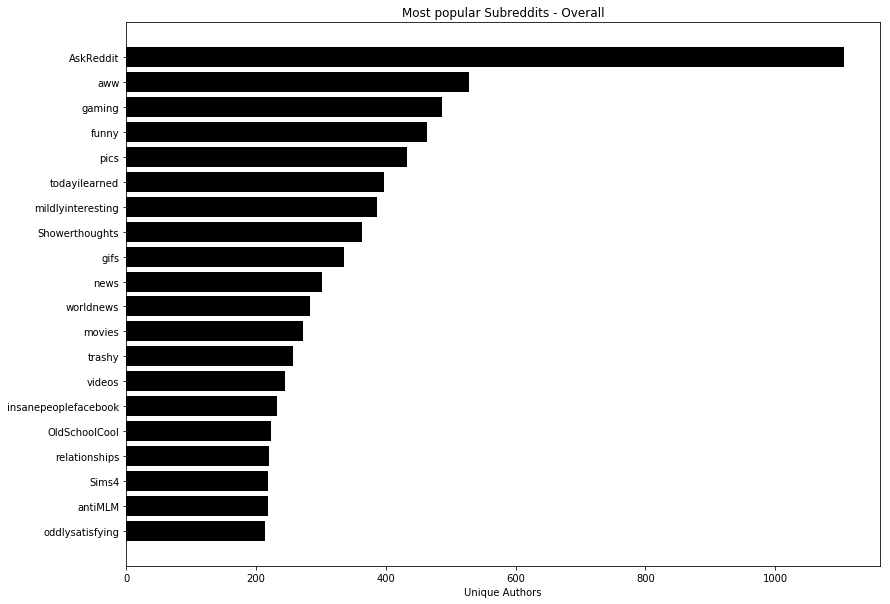

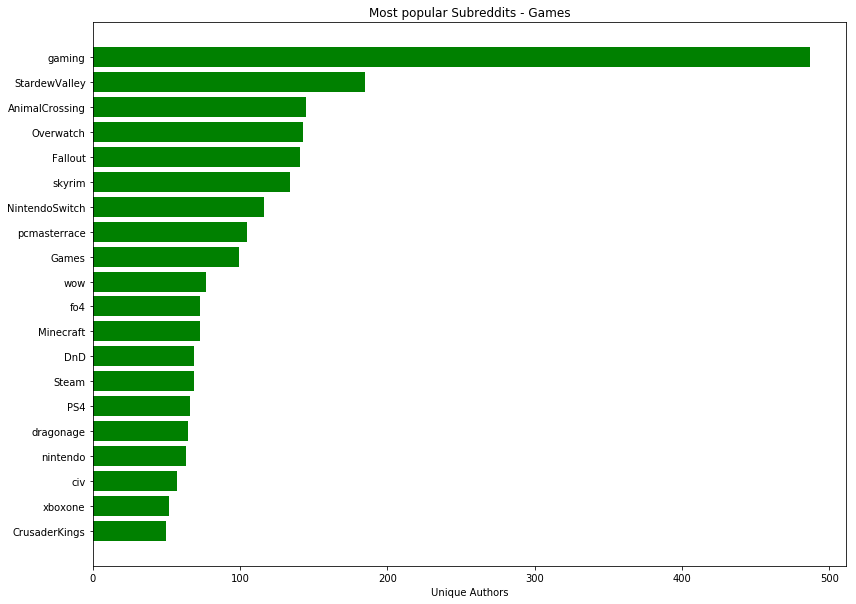

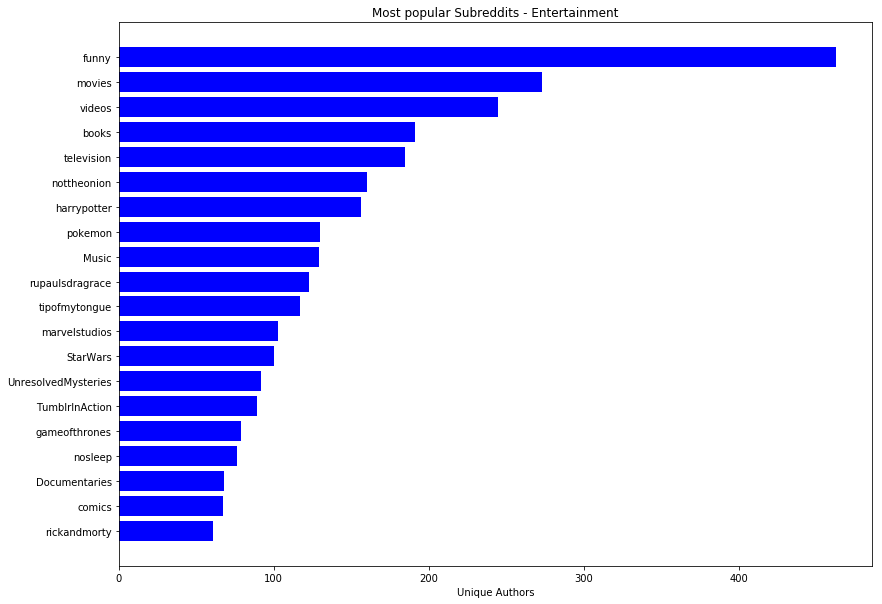

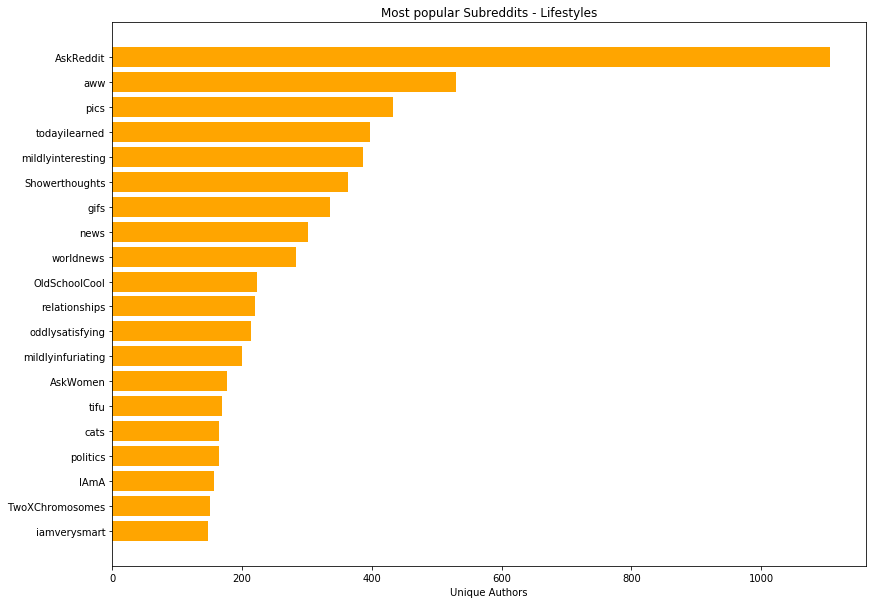

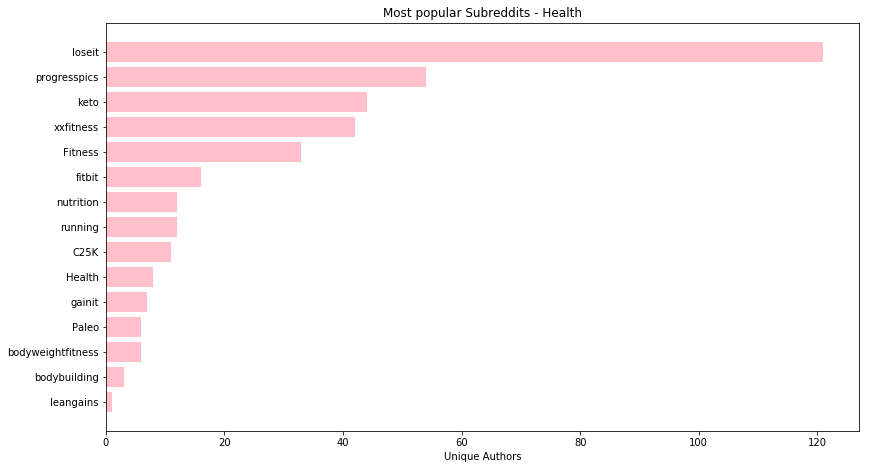

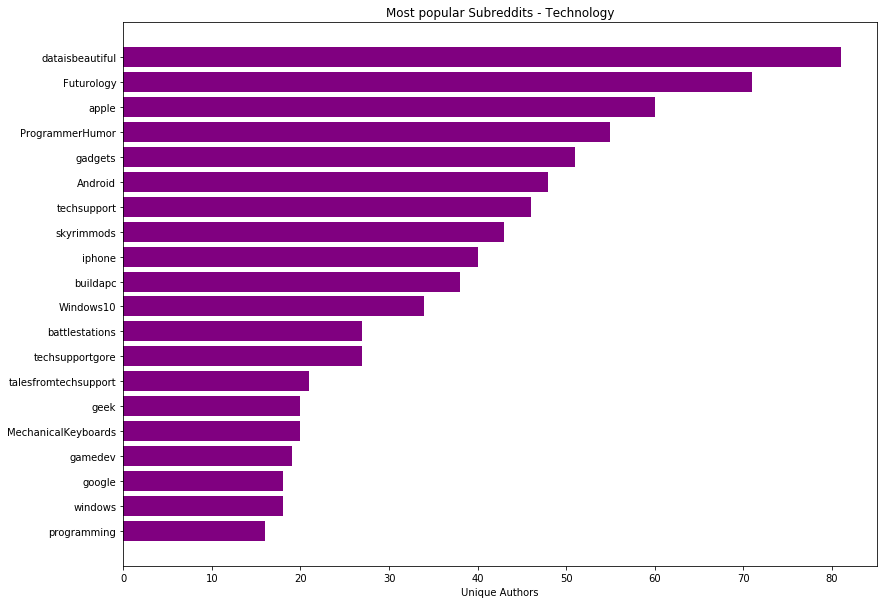

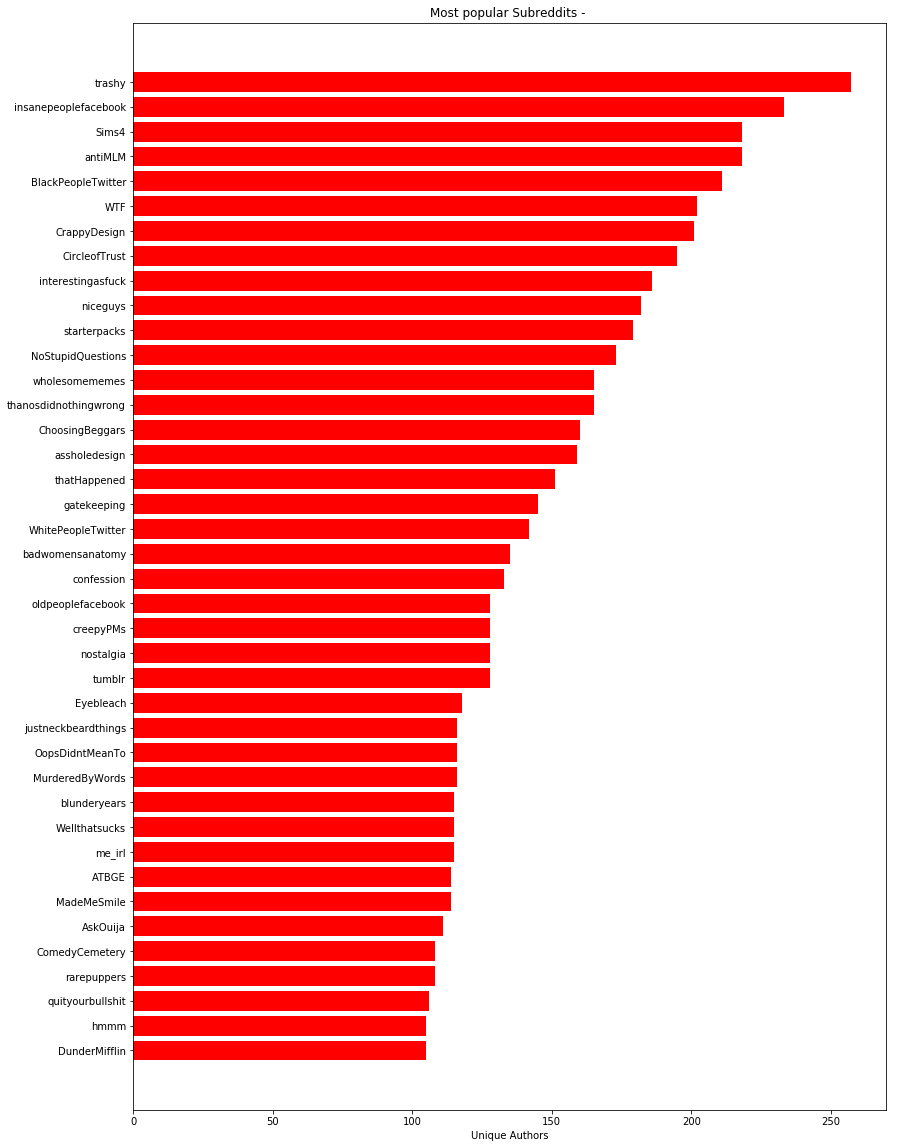

In [24]:
# Prep plotting data
top_n = 10

print("Advertising categories are: " + ", ".join([str(x) for x in data_sum.advertiser_category.unique()]))

# Function to plot bar graphs
def plot_popular_subreddits(data_sum, advertiser_category=None, top_n=10, fill_color='black'):
    data_plot = data_sum.loc[data_sum.subreddit != 'thesims']
    advertiser_category_label = 'Overall'
    if advertiser_category is not None:
        data_plot = data_plot.loc[data_sum.advertiser_category == advertiser_category]
        advertiser_category_label = advertiser_category.capitalize()
    data_plot = data_plot.sort_values(['authors'], ascending=False).head(top_n)
    
    # Plot popular subreddits
    f, ax = plt.subplots()
    f.set_figheight(top_n/2)
    f.set_figwidth(13.5)

    rect = ax.barh(range(top_n), data_plot.authors, color=fill_color, label='Authors')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(data_plot.subreddit)
    # for tick in ax.get_yticklabels(): tick.set_rotation(90)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Unique Authors')
    ax.set_title('Most popular Subreddits - ' + advertiser_category_label)
    plt.plot()
    
plot_popular_subreddits(data_sum, top_n=20)
plot_popular_subreddits(data_sum, advertiser_category='Games', top_n=20, fill_color='green')
plot_popular_subreddits(data_sum, advertiser_category='Entertainment', top_n=20, fill_color='blue')
plot_popular_subreddits(data_sum, advertiser_category='Lifestyles', top_n=20, fill_color='orange')
plot_popular_subreddits(data_sum, advertiser_category='Health', top_n=15, fill_color='pink')
plot_popular_subreddits(data_sum, advertiser_category='Technology', top_n=20, fill_color='purple')
plot_popular_subreddits(data_sum, advertiser_category='', top_n=40, fill_color='red')

The most popular subreddit in terms of user participation is **AskReddit** (discussion Q&A), **aww** (cute animal pics/gifs/vids), **funny** (funny media), and **gaming** (all things games).

We should choose to count authors rather than comments and posts since some subreddits are more tailored to discussions or some authors are more prolific content creators or verbose than others.

In [25]:
data_sum.sort_values(['posts'], ascending=False).head(10)

,advertiser_category,subreddit,posts,comments,authors
13349,Games,thesims,3568.0,42685.0,2000
13382,Lifestyles,AskReddit,660.0,55697.0,1106
5473,,Sims4,309.0,1720.0,218
2894,,HistoryWhatIf,207.0,67.0,4
2892,,HistoricalWhatIf,207.0,33.0,2
13273,Games,Overwatch,199.0,3570.0,143
4309,,NoStupidQuestions,194.0,2729.0,173
12267,,tumblr,183.0,1200.0,128
13449,Lifestyles,aww,175.0,3316.0,529
1315,,CircleofTrust,159.0,1264.0,195


## Network Graph
Since we have user activity in subreddit communities then we could connect users with each other based on how many shared subreddits they have. In order to do this we would have to perform a cartesian join between users based on subreddit.

First let's start by making a unique list of authors and subreddits.

In [26]:
# Unique authors and subreddits
user_subreddit_df = data_sub[['author','subreddit']].drop_duplicates()
user_subreddit_df.head()

# Remove 'thesims' since we know for a fact that everyone in this list commented/posted on it
user_subreddit_df = user_subreddit_df[user_subreddit_df.subreddit != 'thesims']

# Cross Join
edge_df = pd.merge(user_subreddit_df, user_subreddit_df, how='outer', on='subreddit')

# Remove redunduant edges and self-joins on the same author
edge_df = edge_df[edge_df.author_x > edge_df.author_y]
edge_df.head()

,author_x,subreddit,author_y
1,coolibahtree,unpopularopinion,TheGreenPlumbBob
2,coolibahtree,unpopularopinion,ExtraordinarySuccess
3,coolibahtree,unpopularopinion,TT454
5,coolibahtree,unpopularopinion,Korlac11
7,coolibahtree,unpopularopinion,Chernushka


In [27]:
# After the cross join, count the connections between users as the weight of their connection
edge_sum = edge_df.groupby(['author_x','author_y']).agg({'subreddit': 'count'})
edge_sum = edge_sum.reset_index()

edge_sum.head()

,author_x,author_y,subreddit
0,-Sugarholic-,-Rue-,4
1,-This-Is-Not-A-Test-,-Flossie-,1
2,-This-Is-Not-A-Test-,-Rue-,3
3,-This-Is-Not-A-Test-,-Sugarholic-,8
4,-bubblepop,-Rue-,3


### Form Graph
Now that we have the connections between users defined, we can start creating a graph that shows the strength of these connections. We also want to place them in a layout that's more interpretable and appealing.

In [28]:
# Rename columns
edge_sum.columns = ['source', 'target', 'weight']

# Make integer keys for igraphs
authors_df = edge_sum[['source']].rename(columns={'source':'author'}) \
    .append(edge_sum[['target']].rename(columns={'target':'author'}))
authors_df = authors_df.drop_duplicates().reset_index()
authors_df['index'] = authors_df.index

# Join the edge table to get index values
edge_df = pd.merge(edge_sum, authors_df, how='left', left_on='source', right_on='author')
edge_df = edge_df.rename(columns={'index':'index_source'})
edge_df = pd.merge(edge_df, authors_df, how='left', left_on='target', right_on='author')
edge_df = edge_df.rename(columns={'index':'index_target'})

# Make tuple for igraph's add_edges
tuples = [tuple(x) for x in edge_df[['index_source', 'index_target']].values]

# Using igraphs
G = Graph()
G.add_vertices(authors_df.author.values)
G.add_edges(tuples)
G.es['weight'] = edge_sum.weight.values

print("Graph created with n = {0} Nodes and m = {1} Edges".format(G.vcount(), G.ecount()))
edge_sum.head()

Graph created with n = 1942 Nodes and m = 1003359 Edges


,source,target,weight
0,-Sugarholic-,-Rue-,4
1,-This-Is-Not-A-Test-,-Flossie-,1
2,-This-Is-Not-A-Test-,-Rue-,3
3,-This-Is-Not-A-Test-,-Sugarholic-,8
4,-bubblepop,-Rue-,3


In order to read the visualization better we need to make a layout. There are various methods to choose from, but we want to choose an algorithm that can group

In [29]:
# Prepare the graph's layout
# layout = G.layout("fruchterman_reingold")
# layout = G.layout_lgl(maxiter=5, maxdelta=G.vcount(), coolexp=0.99)
# layout = G.layout_grid_fruchterman_reingold(maxiter=500, maxdelta=G.vcount(), coolexp=0.99, seed=1337)
# layout = G.layout_kamada_kawai(maxiter=200, seed=1337)
ts_start = time()
layout = G.layout_fruchterman_reingold(maxiter=500, weights='weight')
print("Elapsed {0}".format(time() - ts_start))

Elapsed 12.406471967697144


Elapsed 11.406217098236084


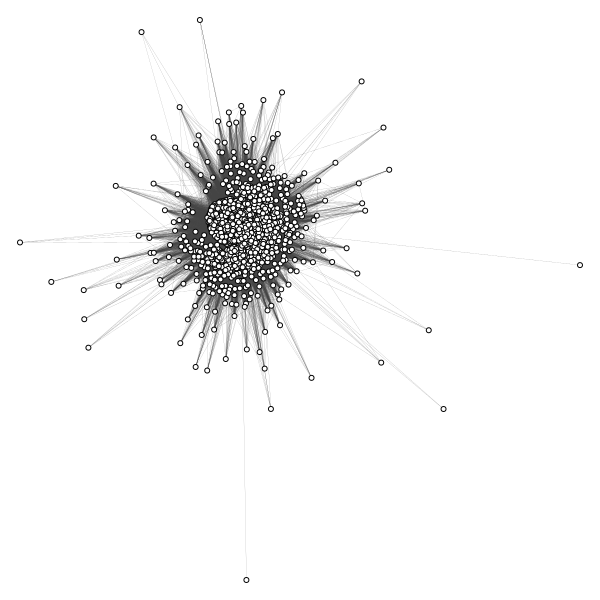

In [30]:
# Plot using the layout provided
# out = igraph.plot(graph, vertex_size=[a/5 for a in graph.betweenness()],
#                       layout = graph.layout('grid'))
ts_start = time()
path_plot_graph = "../docs/figs/graph_layout.png"
out = plot(G, layout=layout, vertex_size=5, edge_width=0.1, vertex_color='white')
out.save(path_plot_graph)
print("Elapsed {0}".format(time() - ts_start))
Image(filename=path_plot_graph) 

### Trimming Edges
There are universally popular subreddits that do not provide much discriminatory power and increase the edge weights. Therefore we can trim the edges so that only we keep only edges that have a weight of 5 or above.

In [31]:
# Trim the edges that do not have strong enough weights
# We identify edges to delete
edge_trim_threshold = 4
# Make a copy and trim
g_trim = G.copy()
g_trim = g_trim.subgraph_edges(g_trim.es.select(weight_gt = edge_trim_threshold))
print("Graph has been trimmed from {0} to {1} edges".format(G.ecount(), g_trim.ecount()))

Graph has been trimmed from 1003359 to 184186 edges


Elapsed 2.4291720390319824


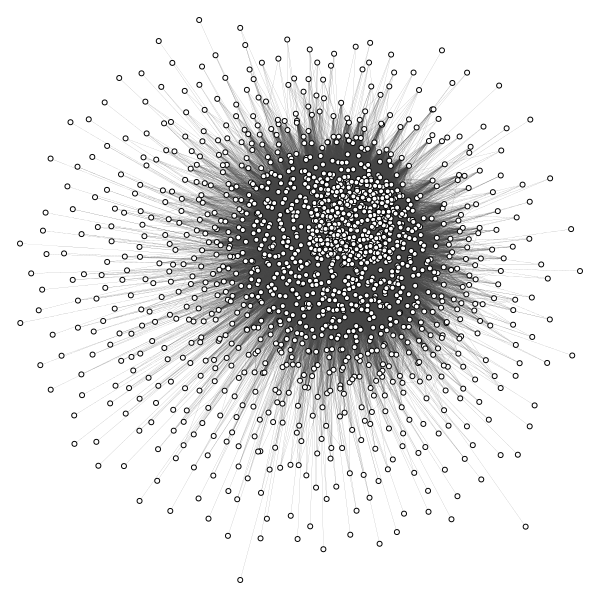

In [32]:
# Replot with trimmed edges
layout_trim = g_trim.layout_lgl(maxiter=500, maxdelta=g_trim.vcount(), coolexp=0.99)
# plot(g_trim, layout=layout_trim, vertex_size=5, edge_width=0.1, vertex_color='white')


ts_start = time()
path_plot_graph_trim = "../docs/figs/graph_layout_trimmed.png"
out = plot(g_trim, layout=layout_trim, vertex_size=5, edge_width=0.1, vertex_color='white')
out.save(path_plot_graph_trim)
print("Elapsed {0}".format(time() - ts_start))
Image(filename=path_plot_graph_trim) 

## Community Detection
We know that not all users in this community are homogenous. Now that we have connections between each user based on common interests we can try to segmenting them by finding some communities.

In [33]:
ts_start = time()

seed(1337)
# g_trim = G.copy()

# Fast Greedy
community_v = g_trim.community_fastgreedy(weights='weight')
community = community_v.as_clustering(n=2)

# Optimal Modularity - GNU Stalls
# community = g_trim.community_optimal_modularity(weights='weight')

# Leading Eigenvector
# community = g_trim.community_leading_eigenvector(clusters = 2, weights='weight')

# Walk trap
# community = g_trim.community_leading_eigenvector(weights='weight')

# Label Propogation
# community = g_trim.community_label_propagation(weights='weight')

# Multilevel Algorithm
# community = g_trim.community_multilevel(weights='weight')

# Edge Betweenness - Takes a long time
# community_v = g_trim.community_edge_betweenness(clusters = 2, weights='weight')
# community = community_v.as_clustering(n=2)

# Info Map
# community = g_trim.community_infomap(edge_weights='weight')


# Assign community to vertex
g_trim.vs["group"] = community.membership


print(str(np.unique(community.membership, return_counts=True)))
print("Elapsed {0}".format(time() - ts_start))

(array([0, 1]), array([898, 678]))
Elapsed 1.5307378768920898


Making Plot using the same layout
Done


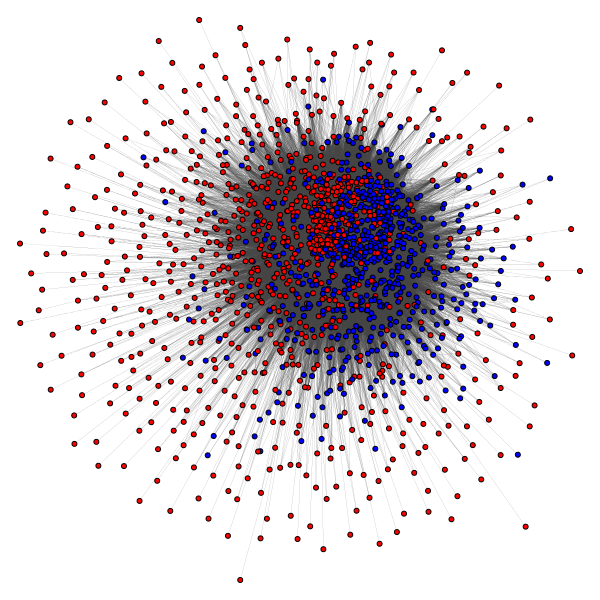

In [34]:
# Replot with trimmed edges
color_list = [
     'red',
     'blue',
     'green',
     'yellow',
     'orange',
     'cyan',
     'pink',
     'grey',
     'white',
     'black',
     'purple'
]

# print("Calculating Layout")
# layout_trim = g_trim.layout_fruchterman_reingold(maxiter=200, weights='weight')

print("Making Plot using the same layout")
path_plot_graph_community_trim = "../docs/figs/graph_layout_community_trimmed.png"
out = plot(g_trim, layout=layout_trim, vertex_size=5, edge_width=0.1, 
     vertex_color=[color_list[mem] for mem in community.membership])
out.save(path_plot_graph_community_trim)

print("Done")
Image(filename=path_plot_graph_community_trim)

### Describe Community
Let's segment these communities by their interests, which will be representated by the subreddits they join.

In [35]:
# Conver to dataframe
author_community = pd.DataFrame({'author': g_trim.vs['name'], 'community': g_trim.vs['group']})
print(author_community.shape)
author_community_sum = author_community.groupby(['community'])['author'].count()
print(author_community_sum)

# Join the community ID to the data
data_mod = pd.merge(data_sub, author_community, how='left', on='author')

# Missing Data
print(data_mod.shape)
data_mod = data_mod[~pd.isnull(data_mod.community)]
print(data_mod.shape)

data_mod.head()

(1576, 2)
community
0    898
1    678
Name: author, dtype: int64
(365610, 7)
(357361, 7)


,author,created_dt,subreddit,advertiser_category,posts,comments,community
0,exotic_hang_glider,2018-05-02,thesims,Games,1.0,3.0,1.0
1,CheesyChips,2018-05-01,thesims,Games,1.0,1.0,1.0
2,crystalshipsx,2018-07-04,thesims,Games,1.0,1.0,0.0
3,PearBlossom,2018-04-02,thesims,Games,1.0,0.0,1.0
4,Axel_The_Sir,2018-06-03,thesims,Games,1.0,0.0,0.0


In [36]:
# Summarise and group by community
data_mod_sum = data_mod.groupby(['community','advertiser_category','subreddit']).agg({'posts':'mean', 'comments':'mean'})

data_mod_sum['authors'] = data_mod.groupby(['community','advertiser_category','subreddit'])['author'].nunique()

data_mod_sum = data_mod_sum.reset_index()
data_mod_sum.head()

,community,advertiser_category,subreddit,posts,comments,authors
0,0.0,,007,1.0,0.0,1
1,0.0,,0xProject,0.0,1.0,1
2,0.0,,100thieves,0.0,1.0,1
3,0.0,,100yearsago,0.0,2.0,1
4,0.0,,1200isfineIGUESSugh,0.0,1.0,1


# Differentiating Groups
What makes these two groups different? How can we explain their difference? One way is to look at the proportion of unique users in each respective group and compare the differences. What subreddits do group 1 have more proportion of people in than group 2 or visa-versa?

In [37]:
# Get total authors for each community
author_df = pd.DataFrame(data_mod.groupby(['community'])['author'].nunique()).reset_index()
author_df = author_df.rename(columns={'author': 'authors_total'})

# Join the authors
data_mod_sum_2 = pd.merge(data_mod_sum, author_df, how='left', on='community')

# Calculate proportion
data_mod_sum_2['proportion'] = data_mod_sum_2.authors/data_mod_sum_2.authors_total
data_mod_sum_2.head()

,community,advertiser_category,subreddit,posts,comments,authors,authors_total,proportion
0,0.0,,007,1.0,0.0,1,898,0.001114
1,0.0,,0xProject,0.0,1.0,1,898,0.001114
2,0.0,,100thieves,0.0,1.0,1,898,0.001114
3,0.0,,100yearsago,0.0,2.0,1,898,0.001114
4,0.0,,1200isfineIGUESSugh,0.0,1.0,1,898,0.001114


,advertiser_category,subreddit,proportion_a,proportion_b,diff
11431,Games,Fallout,0.132517,0.023599,0.108918
11493,Games,gaming,0.342984,0.247788,0.095197
11510,Games,pcmasterrace,0.106904,0.011799,0.095105
11447,Games,NintendoSwitch,0.111359,0.019174,0.092185
11448,Games,Overwatch,0.118040,0.038348,0.079692


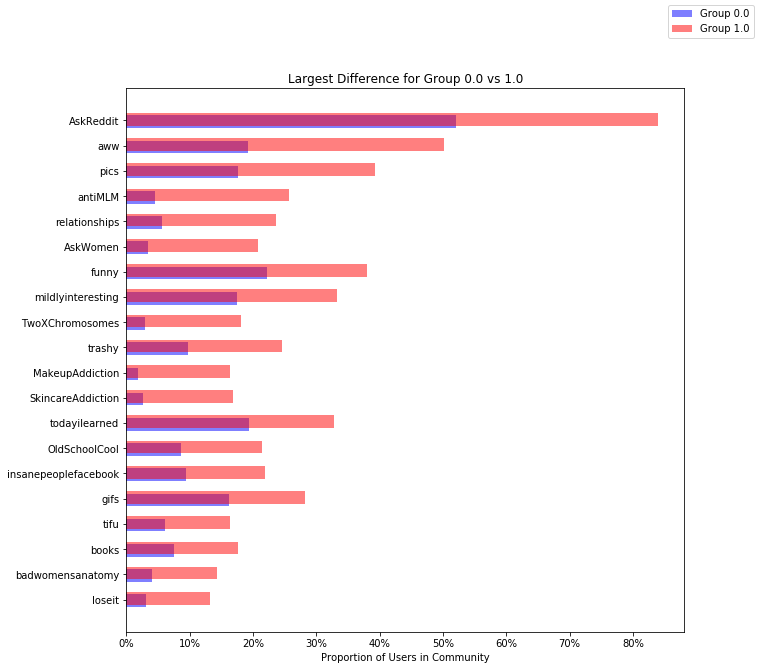

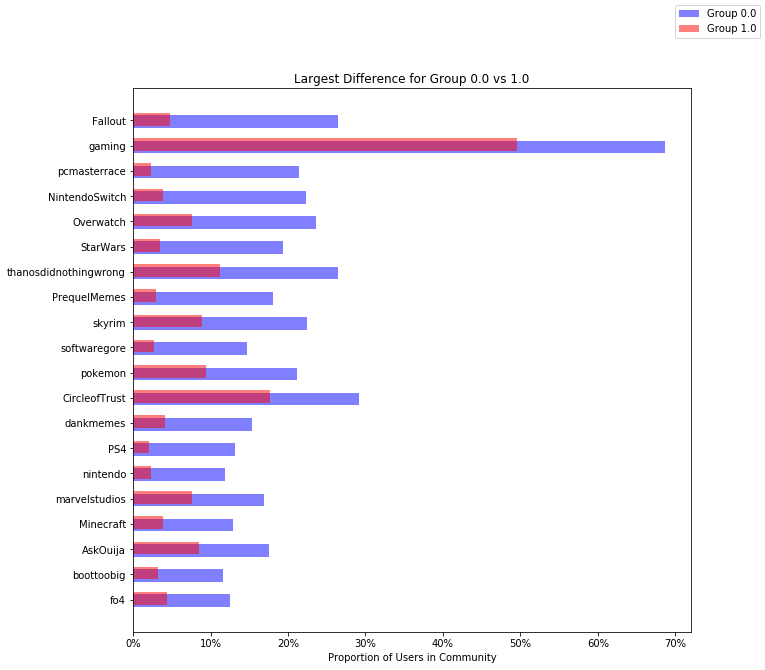

In [38]:

n_communities = np.sort(data_mod_sum_2.community.unique())
proportion_min = 0.01
plot_top_n = 20


# Function to plot bar graphs
def plot_popular_subreddits_diff(data_plot, com_a, com_b, top_n=10, advertiser_category=None):

    # Plot
    bar_width = 0.5
    bar_gap = 0.2
    
    f, ax = plt.subplots()
    f.set_figheight(top_n/2)
    f.set_figwidth(10)

    indices = range(top_n)
    indices_a = [x + bar_width/2 - bar_gap for x in indices]
    indices_b = [x - bar_width/2 + bar_gap for x in indices]

    rect_a = ax.barh(indices_a, data_plot.proportion_a, color='b', label='Group ' + str(com_a), alpha=0.5, height=bar_width)
    rect_b = ax.barh(indices_b, data_plot.proportion_b, color='r', label='Group ' + str(com_b), alpha=0.5, height=bar_width)
    ax.set_yticks(indices)
    ax.set_yticklabels(data_plot.subreddit)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Proportion of Users in Community')
    ax.set_xticklabels(['{:,.0%}'.format(x/10) for x in ax.get_yticks()])
    ax.set_title('Largest Difference for Group ' + str(com_a) + ' vs ' + str(com_b))
    f.legend()


# For every permutation
for comb in combinations(n_communities, 2):
    com_a, com_b = comb
    df_a = data_mod_sum_2[data_mod_sum_2.community == com_a][['advertiser_category','subreddit', 'proportion']] \
    .rename(columns={'proportion':'proportion_a','authors':'authors_a'})
    df_b = data_mod_sum_2[data_mod_sum_2.community == com_b][['advertiser_category','subreddit', 'proportion']] \
    .rename(columns={'proportion':'proportion_b','authors':'authors_b'})
    df_join = pd.merge(df_a, df_b, how='outer', on=['advertiser_category','subreddit'])
    
    # Remove NAs
    df_join['proportion_a'] = df_join['proportion_a'].fillna(0)
    df_join['proportion_b'] = df_join['proportion_b'].fillna(0)
    
    # Find the largest difference
    df_join['diff'] = df_join['proportion_a'] - df_join['proportion_b']
    df_join = df_join[df_join.proportion_a >= proportion_min]
    df_join = df_join[df_join.proportion_b >= proportion_min]
    
    # Sort and plot
    df_join = df_join.sort_values(['diff'])
    data_plot = df_join.head(plot_top_n)
    plot_popular_subreddits_diff(data_plot, com_a, com_b, plot_top_n)
    
    df_join = df_join.sort_values(['diff'], ascending=False)
    data_plot = df_join.head(plot_top_n)
    plot_popular_subreddits_diff(data_plot, com_a, com_b, plot_top_n)
    
df_join.head()

As you can see, the subreddits with larger proportion of users explains the type of users within that community. 

For example in <font color='blue'>**Group 0**</font>, we see higher proportion of users in gaming subreddits like Fallout (Action RPG), gaming (general gaming discussions), pcmasterrace (superiority of PC gaming), NintendoSwitch, and Overwatch (Hero Shooter). There are franchise specific subreddits as well like StarWars, ThanosDidNothingWrong (Defending the antagonist in the Avengers movies), PrequelMemes (memes about Star Wars episodes 1-3), pokemon, and marvelstudios. If we were to label this group, it'd be something along the lines of being a general <font color='blue'>gamer</font> and <font color='blue'>fan of nerd culture</font>.

On the other hand, in <font color='red'>**Group 1**</font> we observe the subreddits that index higher are AskReddit, aww (cute animal pictures), antiMLM (anti Multi Level Marketing or pyramid selling), relationships, AskWomen, TwoXChromosomes (discussion of topics for women), MakeupAddition, SkincareAddiction, etc. This leads us to believe that this community are likely <font color='red'>female</font>.

## Interest by Community
Now that we have a sense of distinct communities we can revisit the popular subreddits according to these groups.



In [39]:
# Function to plot bar graphs
def plot_popular_subreddits_multi(data_sum, advertiser_category=None, top_n=10, fill_color='black', row=1, col=2, plot_index=1):
    data_plot = data_sum.loc[data_sum.subreddit != 'thesims']
    advertiser_category_label = 'Overall'
    if advertiser_category is not None:
        data_plot = data_plot.loc[data_sum.advertiser_category == advertiser_category]
        advertiser_category_label = advertiser_category.capitalize()
        
    # Loop through each community
    communities = data_plot.community.unique()
    f, ax_multi = plt.subplots(1, len(communities), sharex=True, sharey=False)
    for com in communities:

        data_subplot = data_plot.loc[data_plot.community == com]
        data_subplot = data_subplot.sort_values(['authors'], ascending=False).head(top_n)

        # Plot popular subreddits
        ax = ax_multi[int(com)]
        f.set_figheight(top_n/2)
        f.set_figwidth(13)

        rect = ax.barh(range(top_n), data_subplot.proportion, color=fill_color, label='Authors')
        ax.set_yticks(range(top_n))
        ax.set_yticklabels(data_subplot.subreddit)
        ax.set_xticklabels(['{:,.0%}'.format(x/10) for x in ax.get_yticks()])
        # for tick in ax.get_yticklabels(): tick.set_rotation(90)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Unique Authors')
        ax.set_title('Most popular Subreddits - Group ' + str(int(com)) + ' - ' + advertiser_category_label)


# Subreddit - <font color='green'>Gaming</font>

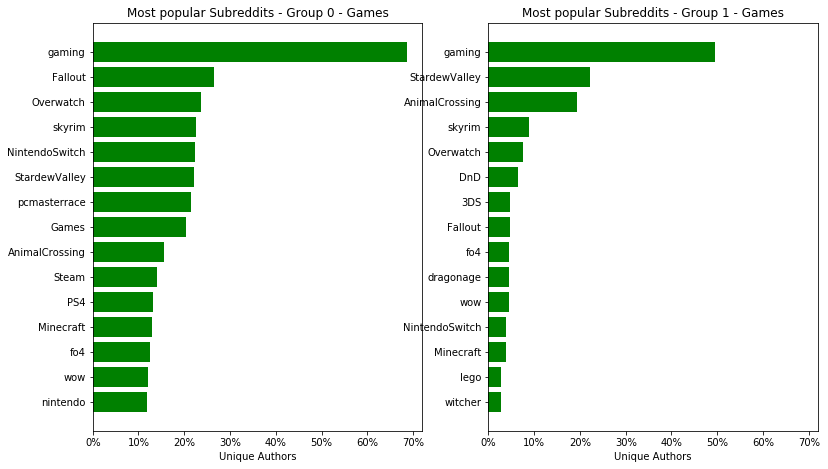

In [40]:
# Gaming
plot_popular_subreddits_multi(data_mod_sum_2, advertiser_category='Games', top_n = 15, fill_color='green')


Let's call <font color='blue'>**Group 0 Gamers**</font> and <font color='red'>**Group 1 Female**</font>. As we can see, the <font color='blue'>**Gamers**</font> community are far more active in gaming subreddits proportionally. They tend to play more immersive games like **Fallout** and **Skyrim**, both open world RPGs. They also play the hero shooter title Overwatch, which is known to have mass appeal. This is inline with our own understanding of player segmentations through surveys and consumer studies.

<table><tr><td style='width: 50%'><img src='https://cdn.wccftech.com/wp-content/uploads/2018/10/fallout-76-logo.jpg'></td><td><img src='https://i.ytimg.com/vi/sis8GfE4BGQ/maxresdefault.jpg'></td></tr></table>

<table><tr><td style='width: 50%'><img src='https://1000logos.net/wp-content/uploads/2018/01/overwatch-logo.png'></td><td><img src='https://blizzardwatch.com/wp-content/uploads/2015/10/overwatch_gameplay_header.jpg'></td></tr></table>

<table><tr><td style='width: 50%'><img src='https://hb.imgix.net/56c03309642be6d3a455693251d3718f85706063.jpg?auto=compress,format&fit=crop&h=353&w=616&s=cff1e330cce7d86e5c89a96b200f869c'></td><td><img src='https://cdn.pocket-lint.com/r/s/970x/assets/images/144143-ar-vr-review-skyrim-vr-review-the-best-version-of-skyrim-yet-image2-zzmdrqtip4.jpg'></td></tr></table>


On the other hand <font color='red'>**Female**</font> community do not post heavily in specific game's subreddits except for **Stardew Valley** and **Animal Crossing**. This tells us that the main competitor for our female audience in The Sims 4 is Nintendo's Animal Crossing and Stardew Valley, the spiritual successor to Harvest Moon. 

This makes sense since **Animal Crossing** is a social simulation game where you build up relationships and collect resources while you grow. 


<table><tr><td style='width: 50%'><img src='http://animal-crossing.com//assets/icons/share_icon-tw.jpg'></td><td><img src='https://animalcrossingworld.com/wp-content/uploads/2015/10/amiibo-festival-japanese-website-hero-artwork-790x374.jpg'></td></tr></table>



Also, **Stardew Valley** is a farming simulation game that also requires managing resources and building relationships with other characters living in the same village. This fits in with the Sims 4 gameplay.

<table><tr><td style='width: 50%'><img src='https://steamcdn-a.akamaihd.net/steam/apps/413150/header.jpg?t=1544807843'></td><td><img src='https://upload.wikimedia.org/wikipedia/en/9/96/Stardew_valley_screenshot.png'></td></tr></table>


**Action**: 
 -  Perhaps we could adopt some features of Animal Crossing/Stardew Valley into The Sims.
 -  Spend marketing acquisition on similar places Animal Crossing/Stardew Valley would be served in.


# Subreddit - <font color='red'>Entertainment</font>

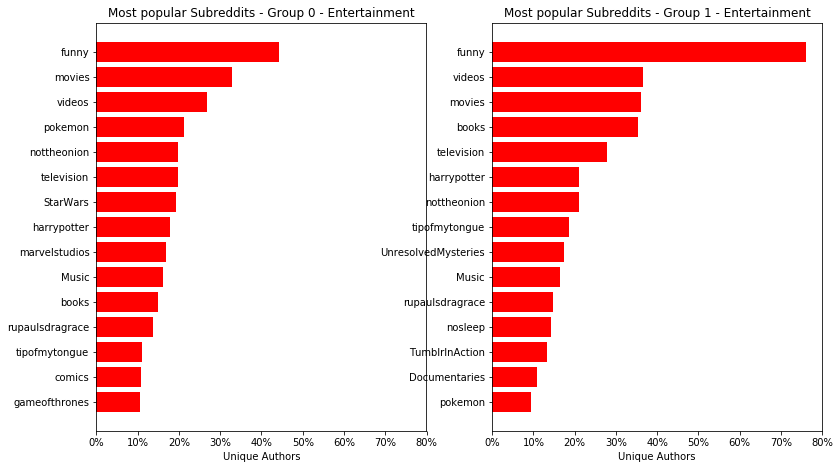

In [41]:
# Entertainment
plot_popular_subreddits_multi(data_mod_sum_2, advertiser_category='Entertainment', top_n = 15, fill_color='red')

The kind of entertainment consumed is of interest to us as game developers takes a lot of themes and story elements into making a game. The IPs that interest <font color='blue'>**Group 0 Gamers**</font> are Marvel, Star Wars and Pokemon, which are the current zeitgeist of nerd and gamer culture.


<table><tr><td style='width: 33%'><img src='https://prodimage.images-bn.com/pimages/9781302912413_p0_v2_s550x406.jpg'></td><td style='width: 33%'><img src='https://www.pixelstalk.net/wp-content/uploads/2016/03/Pikachu-wallpaper-HD-download-desktop.jpg'></td><td><img src='https://upload.wikimedia.org/wikipedia/en/7/7f/Star_Wars_The_Last_Jedi.jpg'></td></tr></table>


<font color='red'>**Group 1 Female**</font> are more readers as shown by the popularity of the books subreddit. The most popular IP is Harry Potter. Interestingly, the subreddit UnsolvedMysteries is popular among this group. It's a collection of real unsolved murders and discussion of shows like Making a Murderer, Serial, and S-Town.

<table><tr><td style='width: 33%'><img src='https://prodimage.images-bn.com/pimages/9780545162074_p0_v2_s550x406.jpg'></td><td style='width: 33%'><img src='https://www.pambazuka.org/sites/default/files/styles/flexslider_full/public/field/image/EW_Harry-Potter_Featured.jpg?itok=XphMvnG2'></td><td><img src='https://files.serialpodcast.org/sites/all/themes/podcast/img/serial-s01-share.jpg'></td></tr></table>

Interestingly Rupaul's Dragrace appears in both communities. It is a reality show fashion competition where contestants are given challenges each week.
<table><tr><td style='width: 33%'><img></td><td style='width: 33%'><img src='https://images-na.ssl-images-amazon.com/images/I/91VBI9ve8pL._RI_.jpg'></td><td><img></td></tr></table>


**Potential Actions**
 - Adding wizards and magic assets to The Sims will be targeting mostly the female audience who may be Harry Potter fans.
 - Include assets that take inspiration of clothing and design from Rupaul's Dragrace.

# Subreddit - <font color='Blue'>Lifestyle</font>

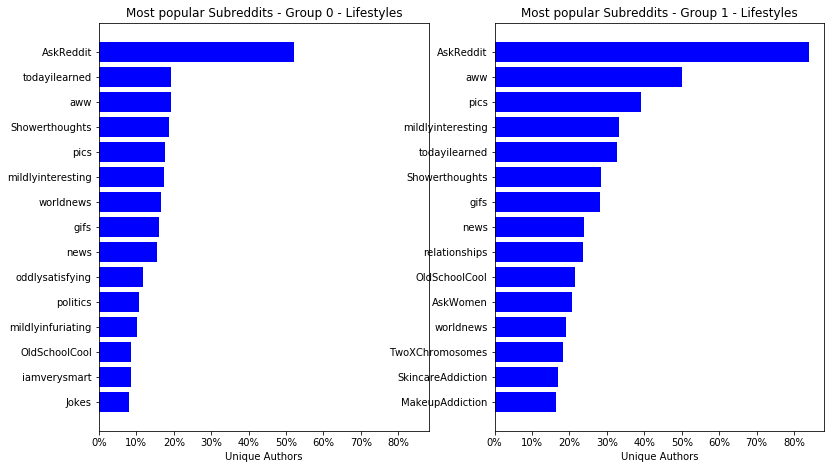

In [42]:
plot_popular_subreddits_multi(data_mod_sum_2, advertiser_category='Lifestyles', top_n=15, fill_color='blue')

The <font color='blue'>**Group 0 Gamers**</font> are a lot less verbose in these Lifestyle subreddits. Some of these subreddits are universally popular. However there are some subreddits that are popular among <font color='red'>**Group 1 Female**</font> that are not in the <font color='blue'>**Group 0 Gamers**</font> community such as relationships, AskWomen, TwoXChomosomes, SkincareAddiction, and MakeupAddiction. As mentioned before this is why we were inclined to think that this group is represented by a female audience.

# Subreddit - <font color='Pink'>Health</font>

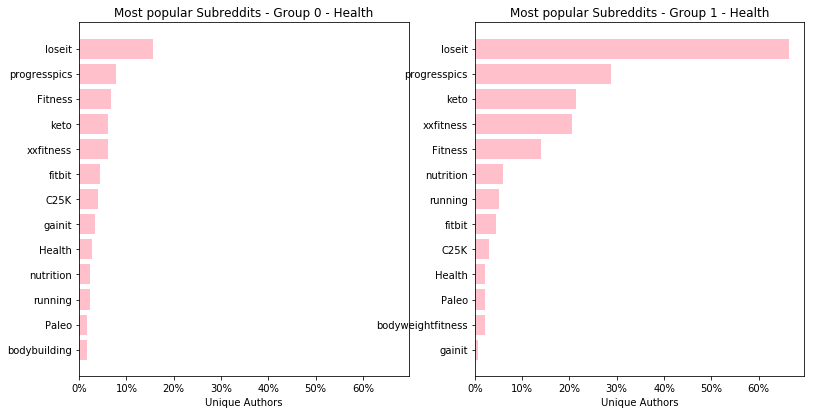

In [43]:
plot_popular_subreddits_multi(data_mod_sum_2, advertiser_category='Health', top_n=13, fill_color='pink')

The main takeaway is that the <font color='red'>**Group 1 Female**</font> community is far more health conscious than the <font color='blue'>**Group 0 Gamers**</font> community. They are far more engaged into Health type subreddit as we can se that majority of the <font color='red'>**Group 1 Female**</font> are in the loseit subreddit about weight loss methods for all body types. There's also lots of interest in progresspics which are users sharing their before and after weightloss pictures and stories.

**Potential Actions**: 
We may want to keep in touch with the latest weight loss trends and make it an option within the Sims. Perhaps even an emphasis on progress towards healthier lifestyles and Sims celebrating milestones might be interesting.

# Subreddit - No Advertiser Category

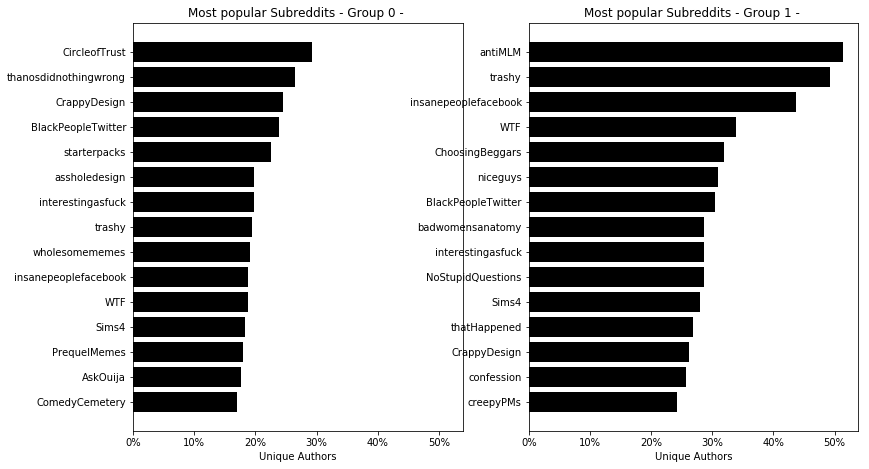

In [44]:
plot_popular_subreddits_multi(data_mod_sum_2, advertiser_category='', top_n=15, fill_color='black')

There are some subreddits that aren't categorized by Reddit's official API. These are also very interesting places that describe the proclivities of the community albeit a bit less traditional. 

The <font color='blue'>**Group 0 Gamers**</font> community likes meme-ey subreddits like CirclofTrust [an April Fools joke subreddit experiment](https://www.reddit.com/r/CircleOfTrustMeta/comments/895qog/what_is_circle_of_trust/), Thanosdidnothingwrong a subreddit that empathizes with Thanos from the Marvel Studios movies, and PrequelMemes a collection of memes using Star Wars episodes 1-3 as a template. 

<table><tr><td style='width: 50%'><img src='https://preview.redd.it/2ifhrd24py711.jpg?width=640&crop=smart&auto=webp&s=3d605af828524795fdb444f3b8f47d24dc177976'></td><td><img src='https://i.redd.it/9cabbn1vwqr11.png'></td></tr></table>


On the other hand <font color='red'>**Group 1 Female**</font> has uniquely popular subreddits as well. An anti-Multi Level Marketing subreddit against selling beauty products and essential oils. Also niceguys and creepyPMs are a collection of screenshots or memes about getting hit on by social inept males. There's also badwomensanatomy that ridicules art in popular culture like cartoons, comics, manga, and anime that overly sexualizes women to inhuman proportion.

<table><tr><td style='width: 50%'><img src='https://preview.redd.it/aqq5fdvamsa21.jpg?width=640&crop=smart&auto=webp&s=15a60b43e37018d7d7919d83a7fa80322a5f23b6'></td><td><img src='https://img.memecdn.com/the-ideal-getaway-for-the-nice-guy_o_5165531.jpg'></td></tr></table>


**Insight**

These meme subreddits along with the Entertainment category suggests that the <font color='blue'>**Group 0 Gamers**</font> audience is more attuned to Marvel and Star Wars categories. Also, it might be interesting for the Sims 4 to add a parody or archtype of "Nice Guys" personalities.

# Other Applications
This is just a cursory analytical look at the potential of using social media like Reddit. There are other appliations:

## Competitive Impact
For example, the CEO of Epic Games, Tim Sweeney has stated about Fortnite's competitive landscape that “*We haven’t seen any visible cut into Fortnite. It’s a funny thing. The only game you can see where its peaks cut into Fortnite playtime is FIFA. It’s another game for everybody, wildly popular around the world*”  [source]
(https://techcrunch.com/2019/03/21/epic-games-ceo-says-apex-legends-hasnt-made-a-dent-in-fortnite). 

We can even see this in how users migrate between gaming subreddits. If there are unsual drops in in-house metrics and they happen to correlate with drops in its subreddit then we can infer where they went.

<table><tr><td style='width: 50%'><img src='https://cdn02.nintendo-europe.com/media/images/10_share_images/games_15/nintendo_switch_4/H2x1_NSwitch_EASportsFifa19_image1600w.jpg'></td><td><img src='https://www.androidcentral.com/sites/androidcentral.com/files/styles/w1600h900crop/public/article_images/2018/03/fortnite-hero%20-%20edited.jpg?itok=aTvkXCvI'></td></tr></table>
<img src='figs/r_fifa_mau_fortnite.png'>

## Topic Models and Sentiment
One thing we have yet to even discuss is the text! There are lots of applications of NLP that can be applied here. For example, EA's mobile game Star Wars Galaxy of Heroes has updates and patches that change the game and inject new content into the ecosystem. This makes the game fresh and interesting, but not all designs are well received by the community.


![swgoh](https://media.contentapi.ea.com/content/dam/eacom/en-us/migrated-images/2016/11/news-article-images-star-wars-goh-splash.jpg.adapt.crop191x100.1200w.jpg)
<table><tr><td style='width: 50%'><img src='figs/r_starwarsgoh_patch_sentiment.png'></td><td><img src='figs/r_starwarsgoh_patch_topics.png'></td></tr></table>


We can monitor the sentiment of the community and identify features that were problematic or contentious for the community.

## Market Basket & Augmenting Recommendations
To build a recommendation system for games, we can look to telemetry for entitlements of our players. However, this is restricted to our own catalogue of games. We have no insight into our players who purchase Activision, Square Enix, Epic, 2K, Rockstar, etc. game. However, you can look at users's collection of subreddits and get a company agnostic basket of games they are engaged in. In addition, we can infer temporal aspects such as an RPG player who recently got into FPS because of a popular event but defaults back into RPGs. 

If we were a company like Netflix or Hulu, it would be a useful platform for discovering which new movies, TV shows, or IPs to fold into the existing catalogue. It might be informative to identify which genre/feature/elements our playerbase is into that we do not fulfill. This can inform what kind of games to make next.

In [45]:
%%HTML
<video width="75%" controls>
  <source src="figs/r_battlefield_one_popular_games.mp4" type="video/mp4">
</video>

## Biases
There are a few caveats from using the data:
 - Biased on White Males late teen to mid twenties
 - English speaking regions (US/CA/GB) as well a some presence from Germany
 - Holiday and external events may impact social media platforms differently from actual engagement in it.